# Initial Imports

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd


from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import scipy.stats as stats

# Preprocessing

In [2]:
raw_SA_df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv")

# Create Low vs High Columns
raw_SA_df["Lv_1_Lo"] = (raw_SA_df["SA1"] < 5).astype(np.bool_)
raw_SA_df["Lv_2_Lo"] = (raw_SA_df["SA2"] < 5).astype(np.bool_)
raw_SA_df["Lv_3_Lo"] = (raw_SA_df["SA3"] < 5).astype(np.bool_)
raw_SA_df["Tot_Lo"] = (raw_SA_df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in raw_SA_df.columns:
    raw_SA_df[col] = raw_SA_df[col].fillna(value = raw_SA_df[col].mean())

# Split up dataset
ids = raw_SA_df["ID"].astype(np.uint8)
outcomes_df = raw_SA_df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]

del col, raw_SA_df

In [3]:
# Load Data (Raw SA Moving Average)
with open("./../../Pickle Files/3_Moving_Average_Raw_SA.pkl", "rb") as f:
    raw_SA_f1_scores, raw_SA_accuracy_scores, raw_SA_CV_models, raw_SA_modified_Ridge_features = pickle.load(f)

In [4]:
# Load Data (Adjusted SA Moving Average)
with open("./../../Pickle Files/3_Moving_Average_Adj_SA.pkl", "rb") as f:
    adj_SA_f1_scores, adj_SA_accuracy_scores, adj_SA_CV_models, adj_SA_modified_Ridge_features = pickle.load(f)

In [ ]:
# Load Data (SMOTE Raw SA Single Observation)
with open("./../../Pickle Files/10_Fold_SMOTE.pkl", "rb") as f:
    SMOTE_f1_scores, SMOTE_accuracy_scores, SMOTE_CV_models, SMOTE_modified_Ridge_features, SMOTE_modified_LASSO_features, SMOTE_f1_scores_shuffled, SMOTE_accuracy_scores_shuffled, SMOTE_CV_models_shuffled, SMOTE_modified_Ridge_features_shuffled, SMOTE_modified_LASSO_features_shuffled = pickle.load(f)

SMOTE_raw_SA_f1_scores = {"Actual": SMOTE_f1_scores, "Shuffled": SMOTE_f1_scores_shuffled}
SMOTE_raw_SA_accuracy_scores = {"Actual": SMOTE_accuracy_scores, "Shuffled": SMOTE_accuracy_scores_shuffled}
SMOTE_raw_SA_CV_models = {"Actual": SMOTE_CV_models, "Shuffled": SMOTE_CV_models_shuffled}
SMOTE_raw_SA_modified_Ridge_features = {"Actual": SMOTE_modified_Ridge_features, "Shuffled": SMOTE_modified_Ridge_features_shuffled}

del SMOTE_f1_scores, SMOTE_accuracy_scores, SMOTE_CV_models, SMOTE_modified_Ridge_features, SMOTE_modified_LASSO_features, SMOTE_f1_scores_shuffled, SMOTE_accuracy_scores_shuffled, SMOTE_CV_models_shuffled, SMOTE_modified_Ridge_features_shuffled, SMOTE_modified_LASSO_features_shuffled

In [ ]:
# Load Data (SMOTE Adjusted SA Single Observation)
with open("./Pickle Files/10_Fold_SMOTE_adjSA.pkl", "rb") as f:
    SMOTE_f1_scores, SMOTE_accuracy_scores, SMOTE_CV_models, SMOTE_modified_Ridge_features, SMOTE_modified_LASSO_features, SMOTE_f1_scores_shuffled, SMOTE_accuracy_scores_shuffled, SMOTE_CV_models_shuffled, SMOTE_modified_Ridge_features_shuffled, SMOTE_modified_LASSO_features_shuffled = pickle.load(f)

SMOTE_adj_SA_f1_scores = {"Actual": SMOTE_f1_scores, "Shuffled": SMOTE_f1_scores_shuffled}
SMOTE_adj_SA_accuracy_scores = {"Actual": SMOTE_accuracy_scores, "Shuffled": SMOTE_accuracy_scores_shuffled}
SMOTE_adj_SA_CV_models = {"Actual": SMOTE_CV_models, "Shuffled": SMOTE_CV_models_shuffled}
SMOTE_adj_SA_modified_Ridge_features = {"Actual": SMOTE_modified_Ridge_features, "Shuffled": SMOTE_modified_Ridge_features_shuffled}

del SMOTE_f1_scores, SMOTE_accuracy_scores, SMOTE_CV_models, SMOTE_modified_Ridge_features, SMOTE_modified_LASSO_features, SMOTE_f1_scores_shuffled, SMOTE_accuracy_scores_shuffled, SMOTE_CV_models_shuffled, SMOTE_modified_Ridge_features_shuffled, SMOTE_modified_LASSO_features_shuffled

In [6]:
def graph_folds(model_1_details, model_2_details, outcomes_df, outcome_var, metric, model_names):
    # Intiailize Baselines (don't need always true line?)
    if metric == "F1":
        baseline = (np.mean(outcomes_df[outcome_var])) / (np.mean(outcomes_df[outcome_var]) + 0.5)
        always_true_line = f1_score(outcomes_df[outcome_var], np.array([1 for _ in range(len(outcomes_df[outcome_var]))]))
    elif metric == "Accuracy":
        baseline = 0.5

    fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)
    fig.set_figheight(7.5)
    fig.set_figwidth(7.5)

    for _, (ax, penalty) in enumerate([(axes[0, 0], "No Penalty"), (axes[0, 1], "Ridge") , (axes[1, 0], "LASSO"), (axes[1, 1], "Modified Ridge (L2)")]):
        model_1_dataset_type = model_1_details["Dataset Type"]
        model_2_dataset_type = model_2_details["Dataset Type"]

        model_1_scores = model_1_details["Scores"][model_1_dataset_type][outcome_var][penalty]
        model_2_scores = model_2_details["Scores"][model_2_dataset_type][outcome_var][penalty]

        # Plot Actual vs Shuffled
        for i, (model_1_score, model_2_score) in enumerate(zip(model_1_scores, model_2_scores)):
            ax.plot([0, 1], [model_1_score, model_2_score], marker = "o", label = f"Test Fold {i + 1}")

        # Model 1 Data Boxplot
        ax.boxplot(model_1_scores, vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        ax.boxplot(model_2_scores, vert = True, positions = [1.1])

        # Baselines
        if metric == "F1":
            ax.axhline(y = always_true_line, color = "r", label = "Always True", linestyle = "--")
        ax.axhline(y = baseline, color = "black", label = "0.5 Line", linestyle = "--")

        # Visual Adjustments
        ax.set_xticks([0, 1], model_names)
        ax.set_xlim([-0.2, 1.2])
        ax.set_ylim([0, 1])

        # Labeling Per Graph
        ax.set_title(penalty)
    
    # Labeling
    fig.supxlabel("Model Type")
    fig.supylabel(f"{metric} Score")
    fig.suptitle(f"{metric} Test Fold Scores for {outcome_var} Models")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.2, 0.9])
    fig.tight_layout()

In [7]:
def paired_t_test(model_1_details, model_2_details, lvl):
    print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
    for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
        t_stat, p_val = stats.ttest_rel(
            model_1_details["Data"][model_1_details["Dataset Type"]][lvl][penalty],
            model_2_details["Data"][model_2_details["Dataset Type"]][lvl][penalty]    
        )
        print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

# Raw SA Actual vs Shuffled

## SA 1

### F1

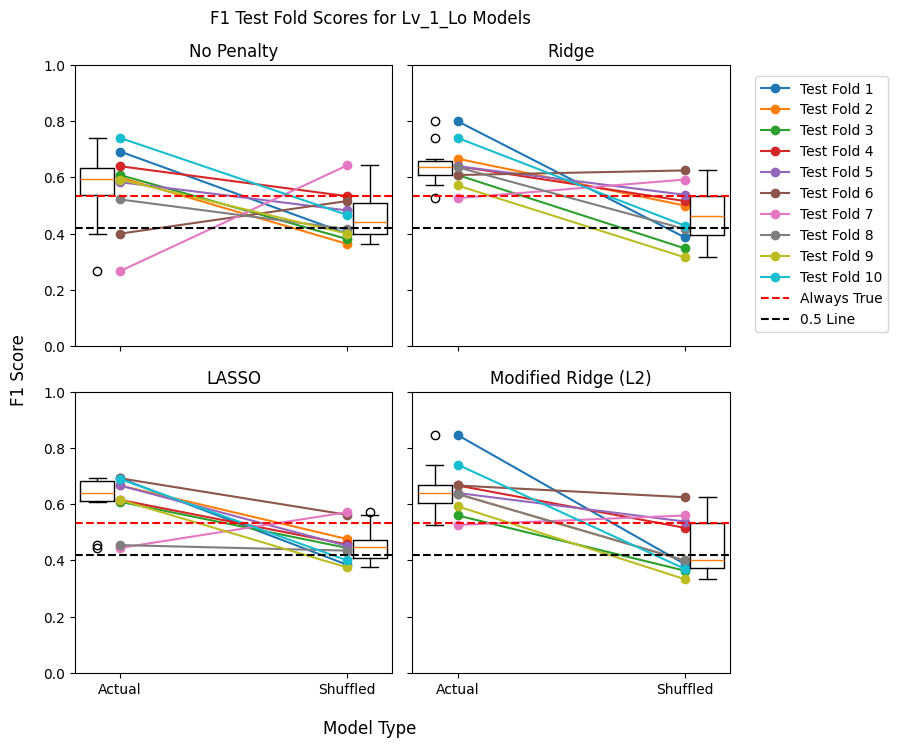

In [11]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

In [12]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_1_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    1.597  0.145
Ridge                         3.813  0.004
Modified Ridge (L2)           4.345  0.002
LASSO                         3.865  0.004


### Accuracy

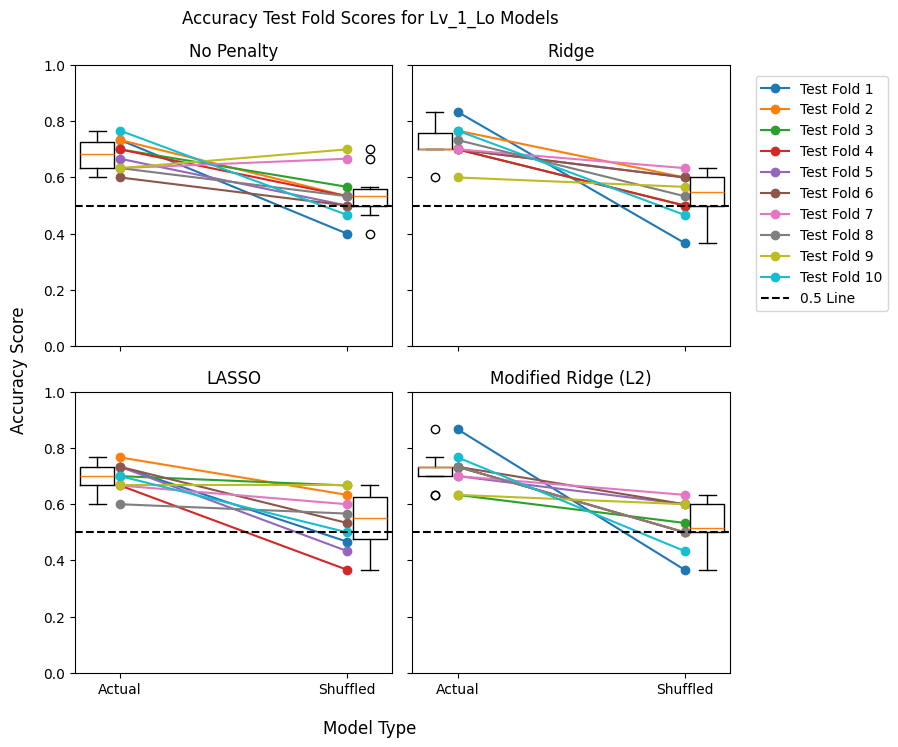

In [12]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

In [13]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_1_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    3.500  0.007
Ridge                         4.568  0.001
Modified Ridge (L2)           4.385  0.002
LASSO                         4.191  0.002


## SA 2

### F1

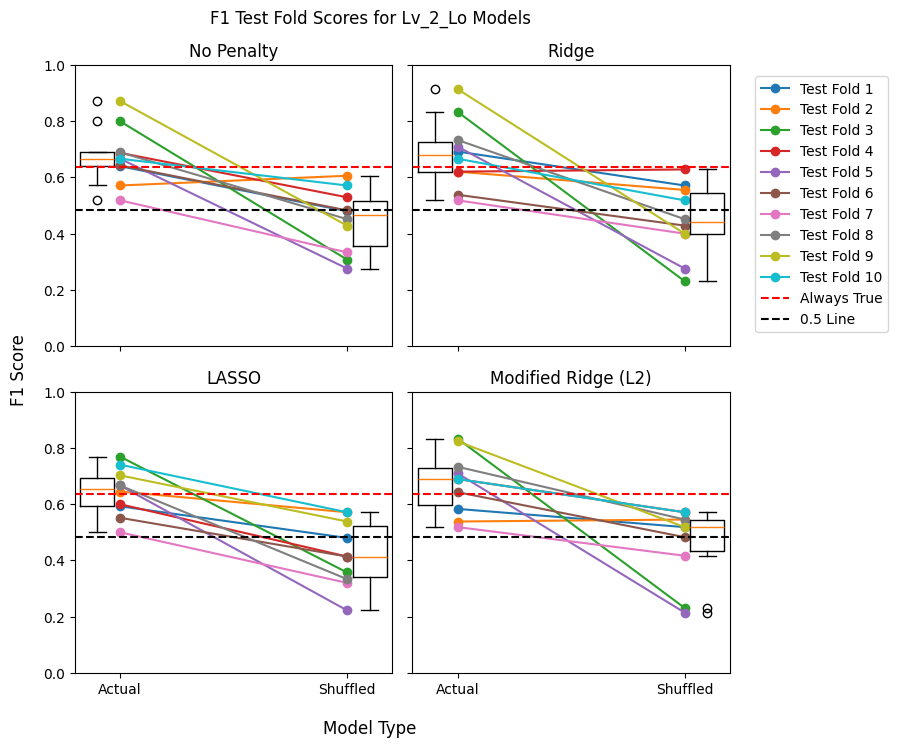

In [13]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

In [14]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_2_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    4.383  0.002
Ridge                         3.616  0.006
Modified Ridge (L2)           3.473  0.007
LASSO                         5.456  0.000


### Accuracy

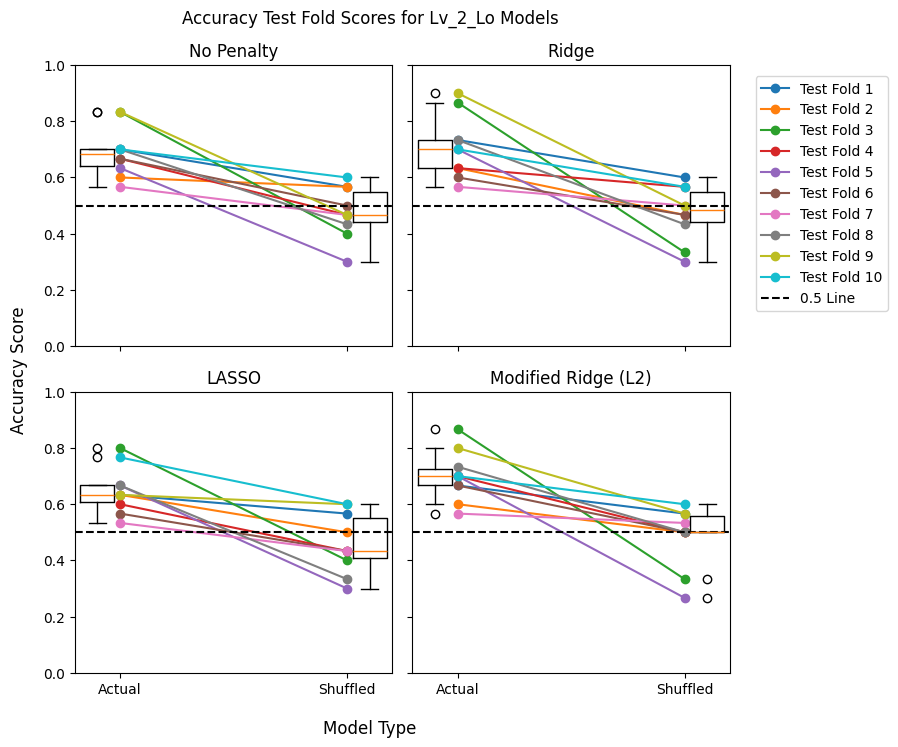

In [14]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

In [15]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_2_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    5.124  0.001
Ridge                         4.518  0.001
Modified Ridge (L2)           4.268  0.002
LASSO                         4.635  0.001


## SA 3

### F1

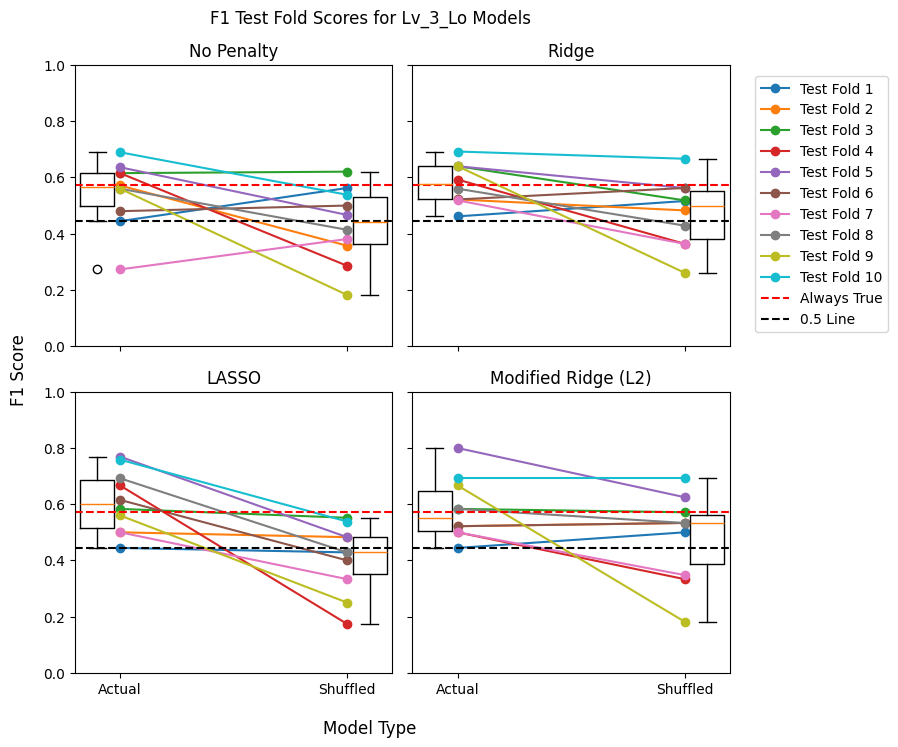

In [15]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

In [16]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_3_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    2.087  0.066
Ridge                         2.585  0.029
Modified Ridge (L2)           1.902  0.090
LASSO                         4.215  0.002


### Accuracy

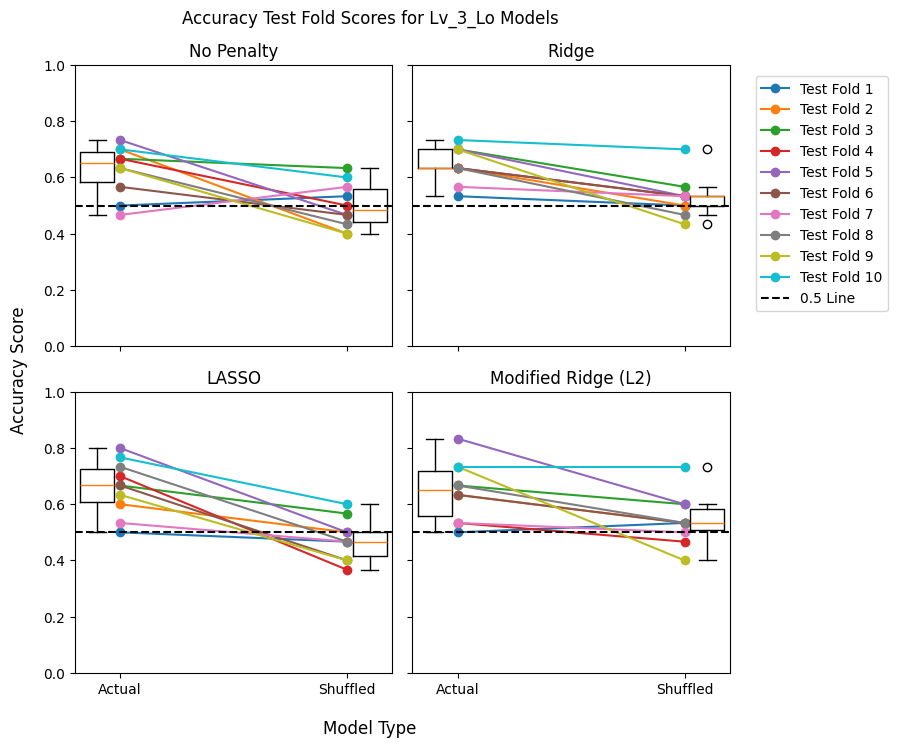

In [16]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

In [17]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_3_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    3.051  0.014
Ridge                         4.977  0.001
Modified Ridge (L2)           2.988  0.015
LASSO                         5.527  0.000


## Total SA

### F1

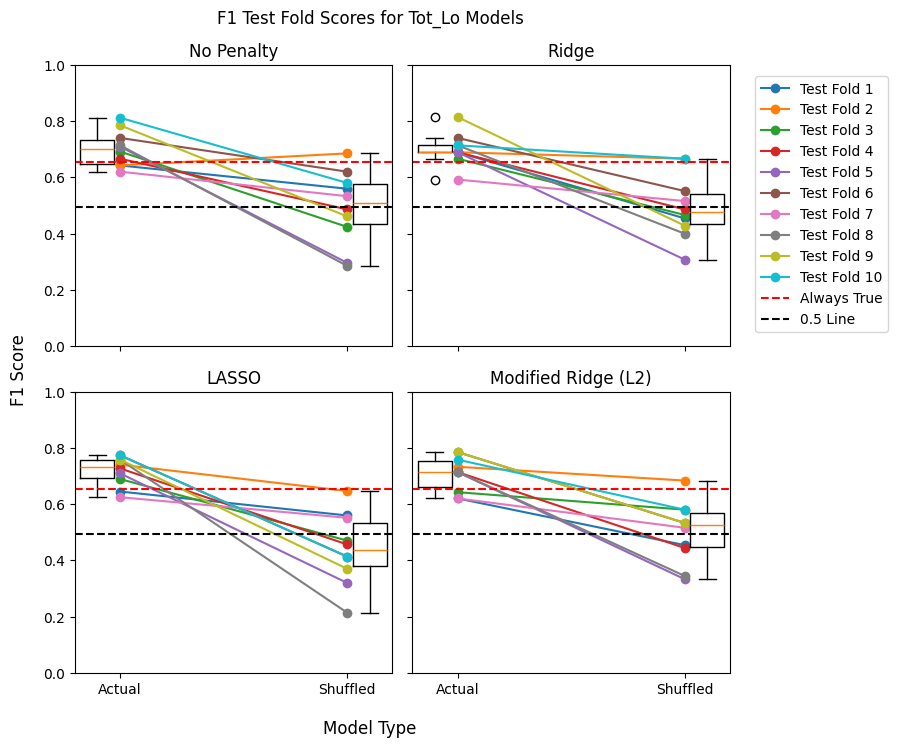

In [17]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

In [18]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Shuffled"
    },
    "Tot_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    4.333  0.002
Ridge                         5.010  0.001
Modified Ridge (L2)           5.627  0.000
LASSO                         5.560  0.000


### Accuracy

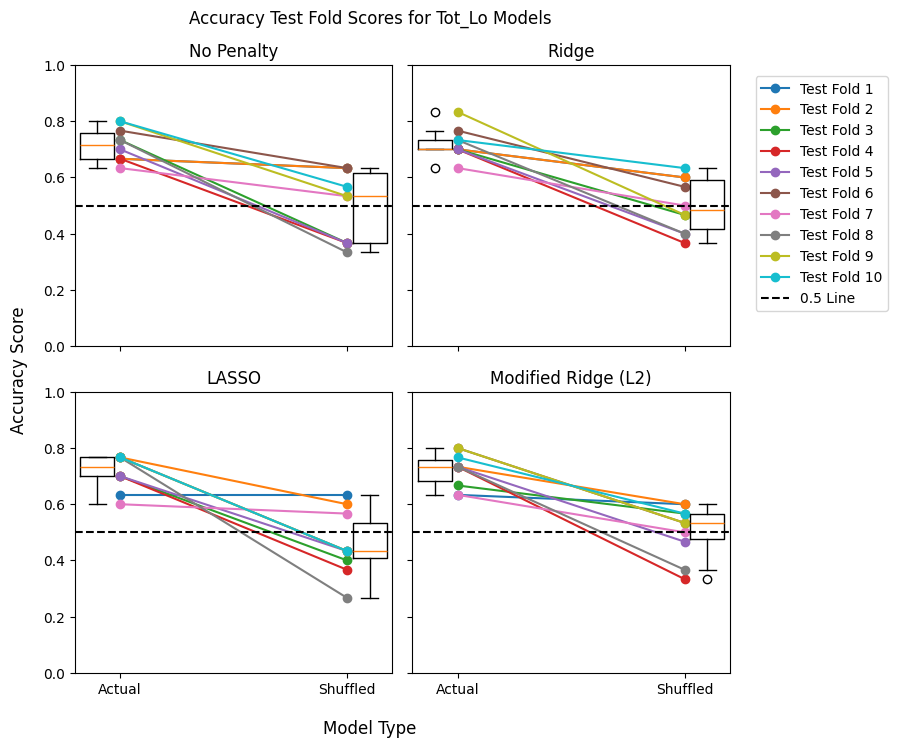

In [18]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

In [19]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Shuffled"
    },
    "Tot_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    5.106  0.001
Ridge                         6.444  0.000
Modified Ridge (L2)           5.814  0.000
LASSO                         5.403  0.000


# Adjusted SA Actual vs Shuffled

## SA 1

### F1

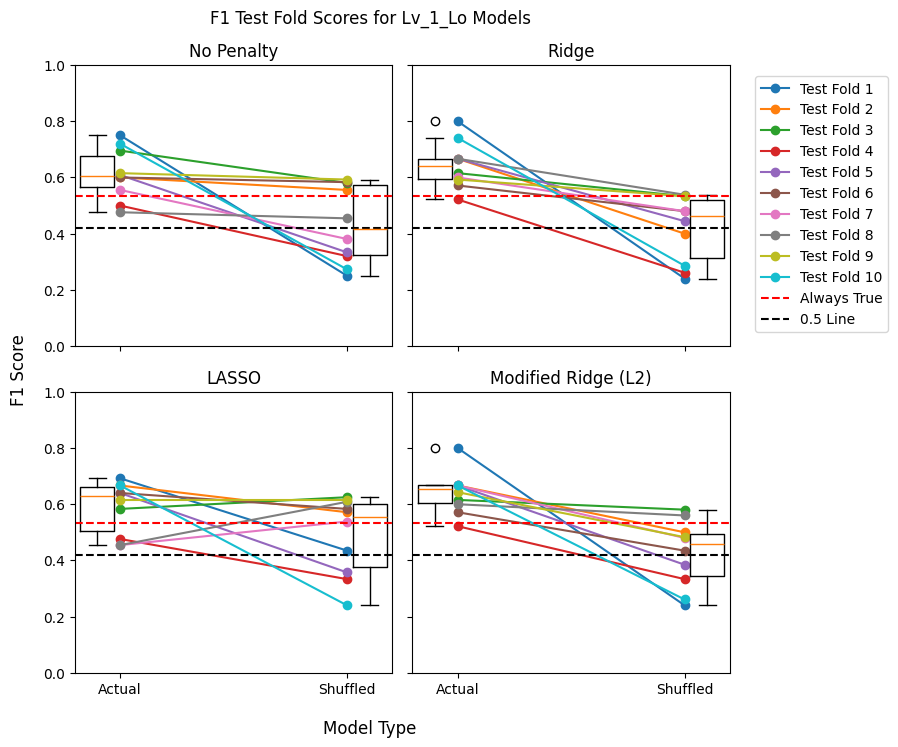

In [19]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

In [8]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_1_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    3.212  0.011
Ridge                         4.225  0.002
Modified Ridge (L2)           4.220  0.002
LASSO                         1.709  0.122


### Accuracy

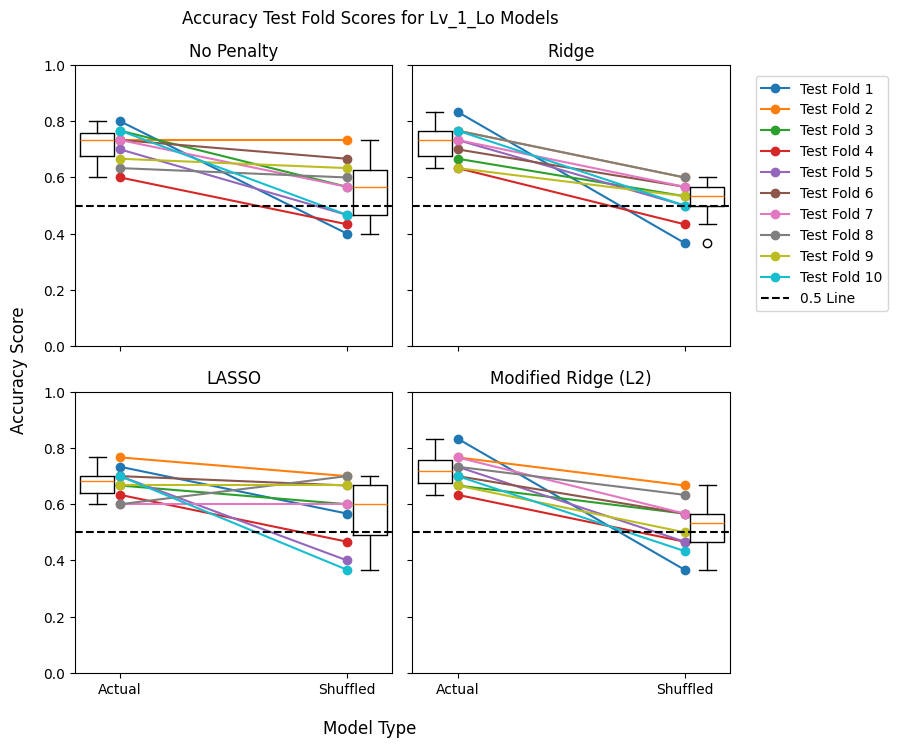

In [20]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": adj_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

In [9]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_1_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    3.911  0.004
Ridge                         6.138  0.000
Modified Ridge (L2)           5.465  0.000
LASSO                         2.378  0.041


## SA 2

### F1

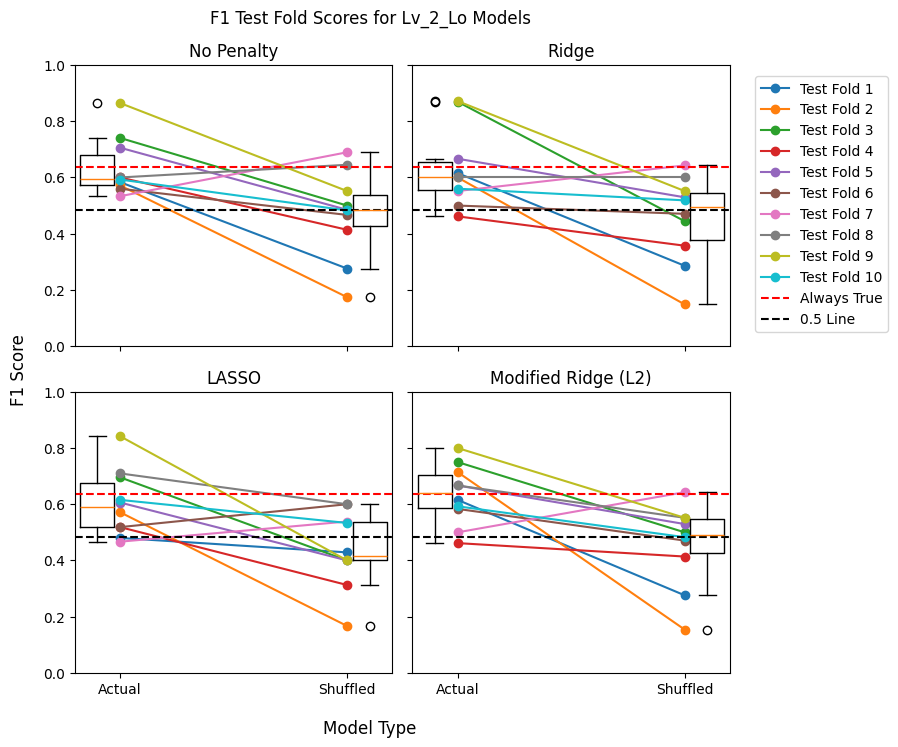

In [21]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

In [10]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_2_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    3.096  0.013
Ridge                         2.882  0.018
Modified Ridge (L2)           2.996  0.015
LASSO                         2.875  0.018


### Accuracy

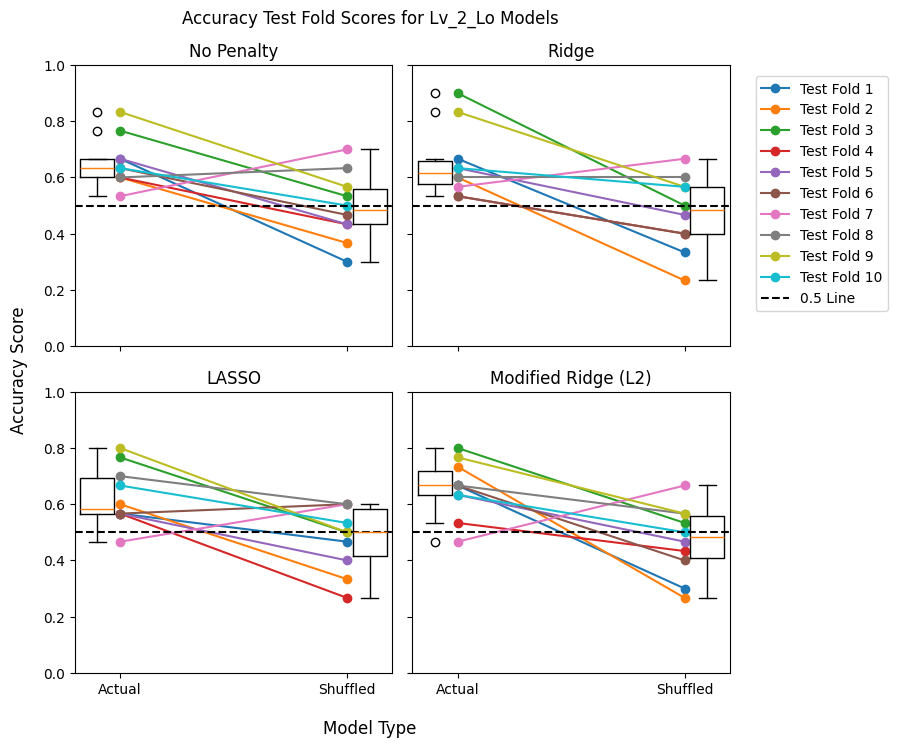

In [22]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": adj_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

In [11]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_2_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    3.273  0.010
Ridge                         3.405  0.008
Modified Ridge (L2)           3.280  0.010
LASSO                         3.179  0.011


## SA 3

### F1

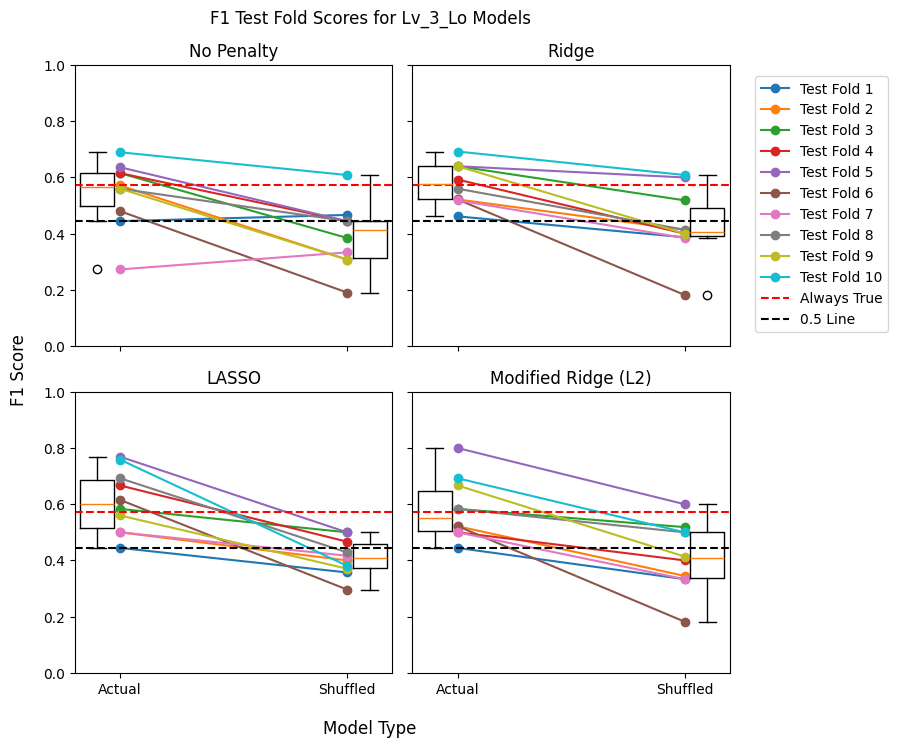

In [23]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

In [12]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_3_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    3.957  0.003
Ridge                         5.269  0.001
Modified Ridge (L2)           6.324  0.000
LASSO                         5.789  0.000


### Accuracy

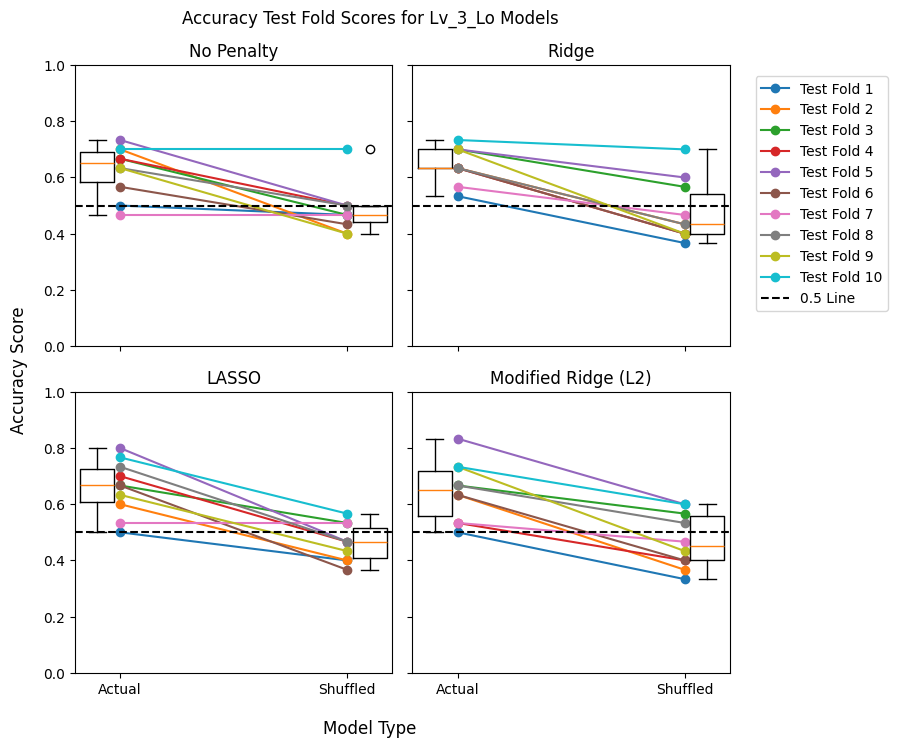

In [24]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": adj_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

In [13]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Shuffled"
    },
    "Lv_3_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    4.346  0.002
Ridge                         6.782  0.000
Modified Ridge (L2)           7.250  0.000
LASSO                         6.301  0.000


## Total SA

### F1

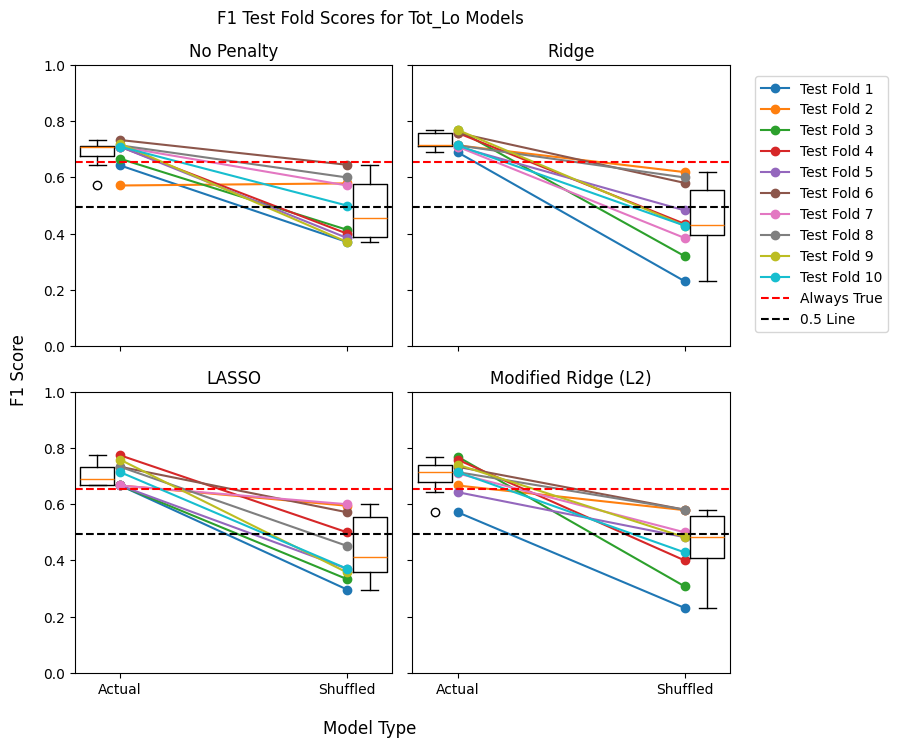

In [25]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

In [14]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Shuffled"
    },
    "Tot_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    5.515  0.000
Ridge                         7.016  0.000
Modified Ridge (L2)           6.572  0.000
LASSO                         6.875  0.000


### Accuracy

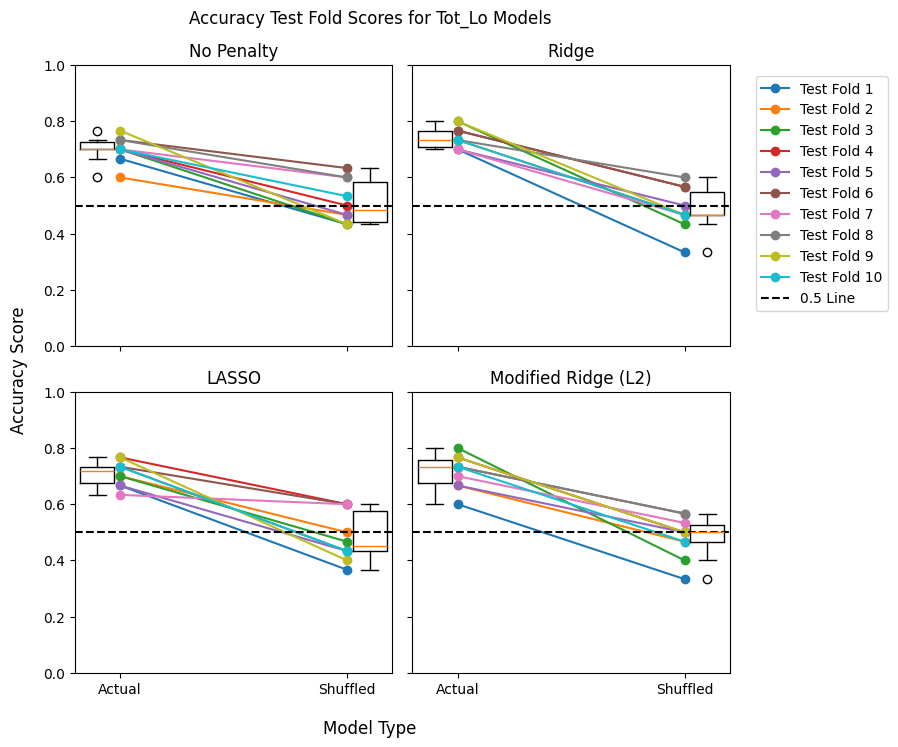

In [26]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": adj_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

In [15]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Shuffled"
    },
    "Tot_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    7.797  0.000
Ridge                         10.320 0.000
Modified Ridge (L2)           9.791  0.000
LASSO                         7.323  0.000


# Raw vs. Adjusted SA

## SA 1

### F1

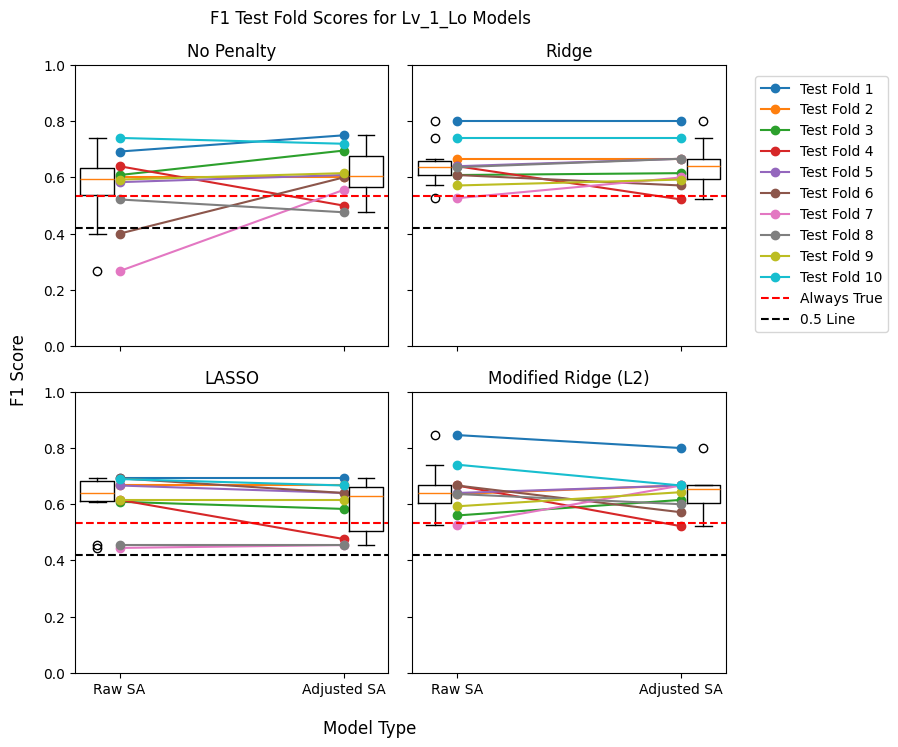

In [27]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "F1", 
    model_names = ["Raw SA", "Adjusted SA"]
)

In [16]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    "Lv_1_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    -1.227 0.251
Ridge                         -0.019 0.986
Modified Ridge (L2)           0.349  0.735
LASSO                         1.838  0.099


### Accuracy

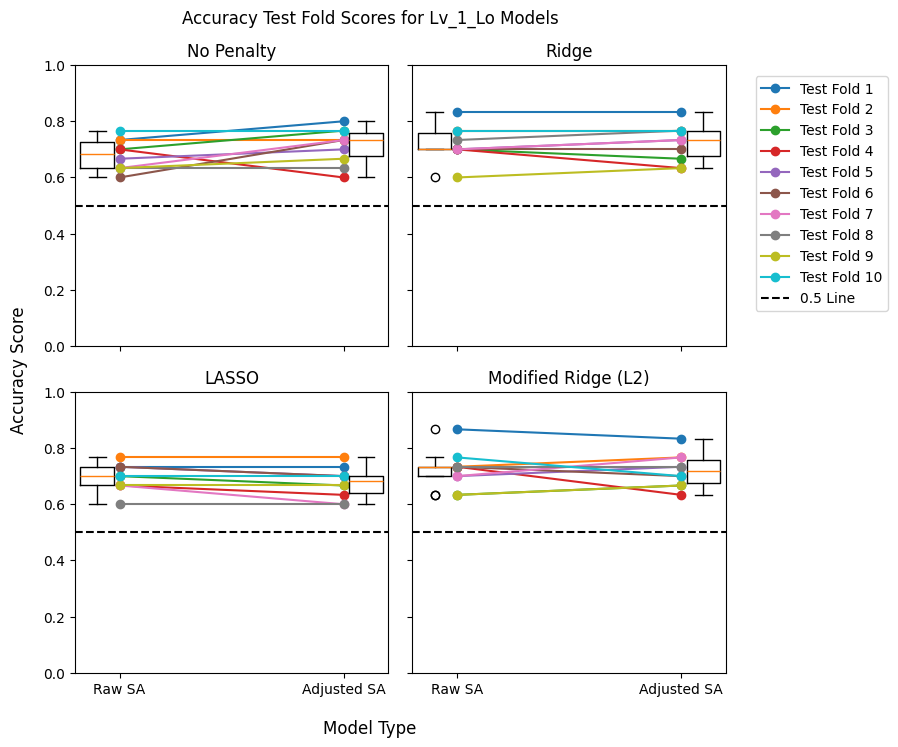

In [28]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "Accuracy", 
    model_names = ["Raw SA", "Adjusted SA"]
)

In [17]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    "Lv_1_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    -1.627 0.138
Ridge                         -0.318 0.758
Modified Ridge (L2)           0.198  0.847
LASSO                         2.714  0.024


## SA 2

### F1

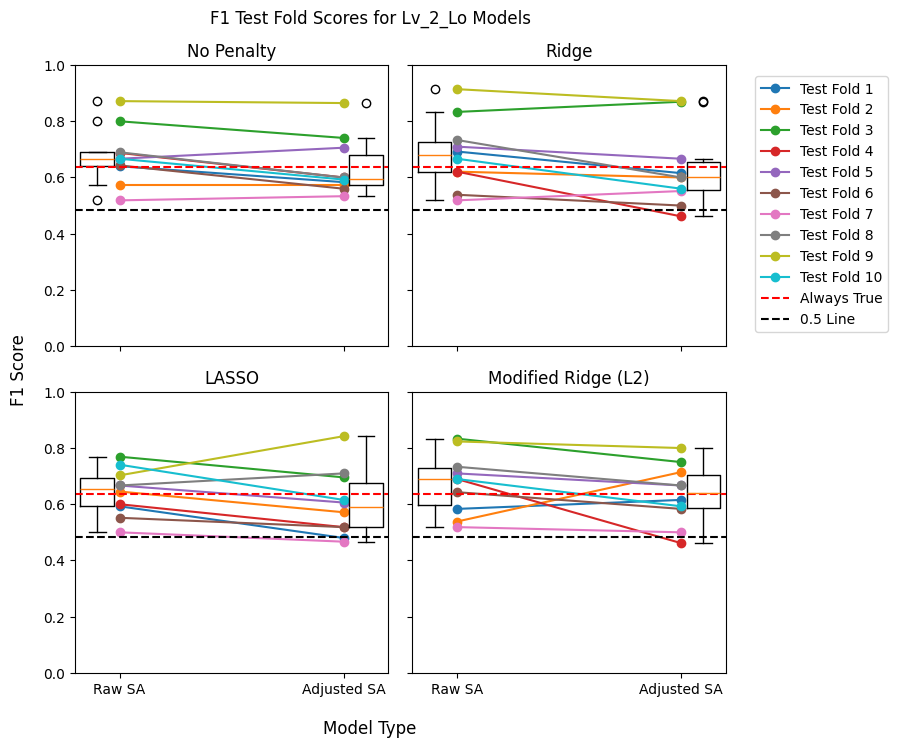

In [29]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "F1", 
    model_names = ["Raw SA", "Adjusted SA"]
)

In [18]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    "Lv_2_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    2.680  0.025
Ridge                         2.683  0.025
Modified Ridge (L2)           1.274  0.235
LASSO                         1.648  0.134


### Accuracy

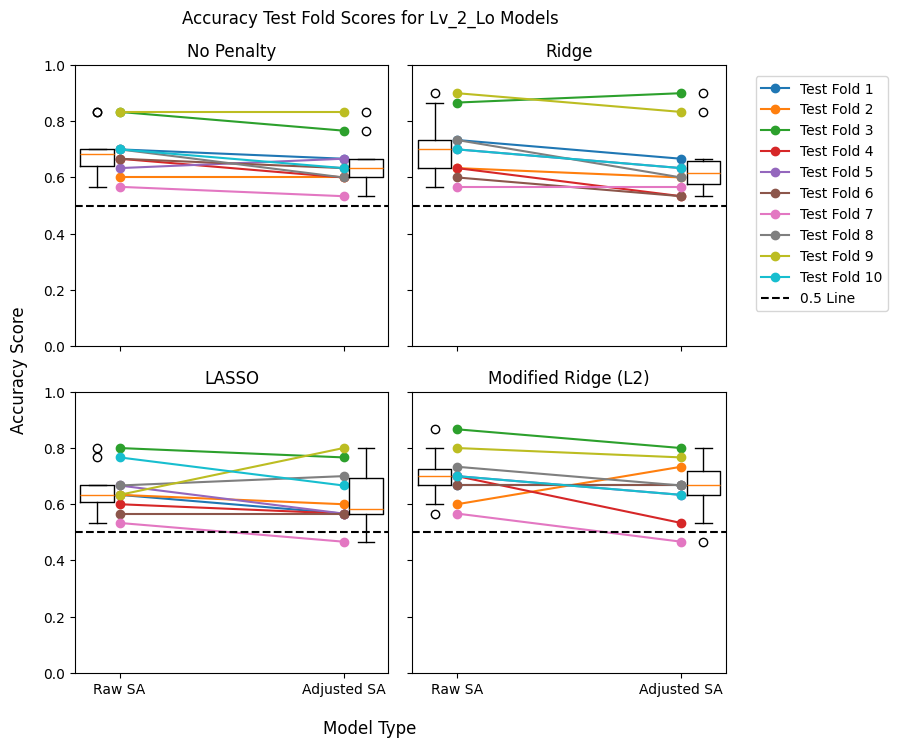

In [30]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "Accuracy", 
    model_names = ["Raw SA", "Adjusted SA"]
)

In [20]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    "Lv_2_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    2.905  0.017
Ridge                         3.791  0.004
Modified Ridge (L2)           1.742  0.115
LASSO                         0.938  0.373


## SA 3

### F1

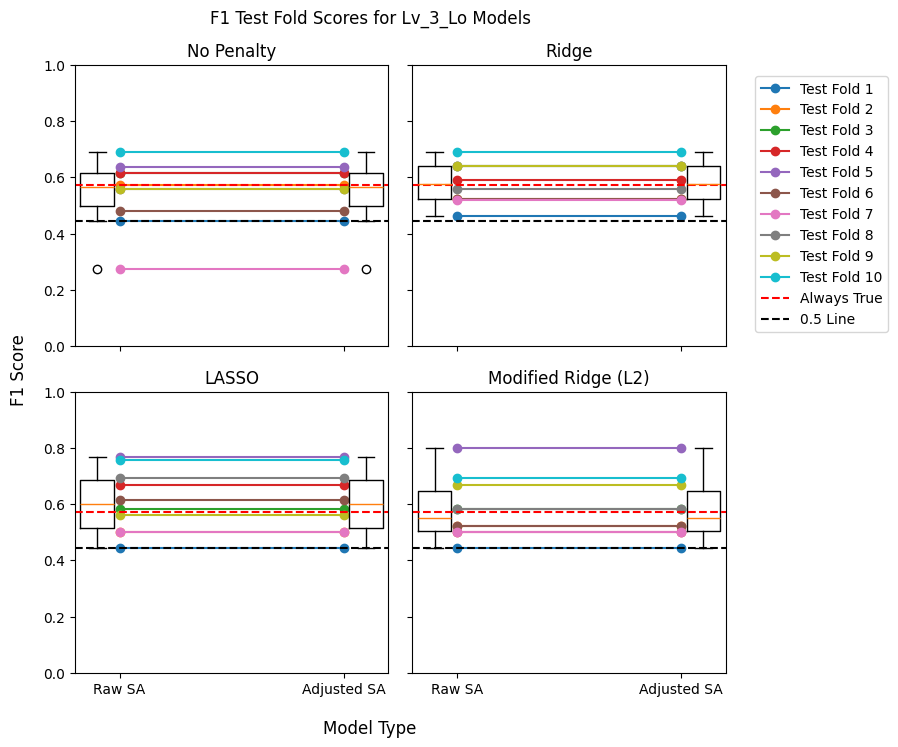

In [31]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "F1", 
    model_names = ["Raw SA", "Adjusted SA"]
)

In [33]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    "Lv_3_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    nan      nan
Ridge                         nan      nan
Modified Ridge (L2)           nan      nan
LASSO                         nan      nan


### Accuracy

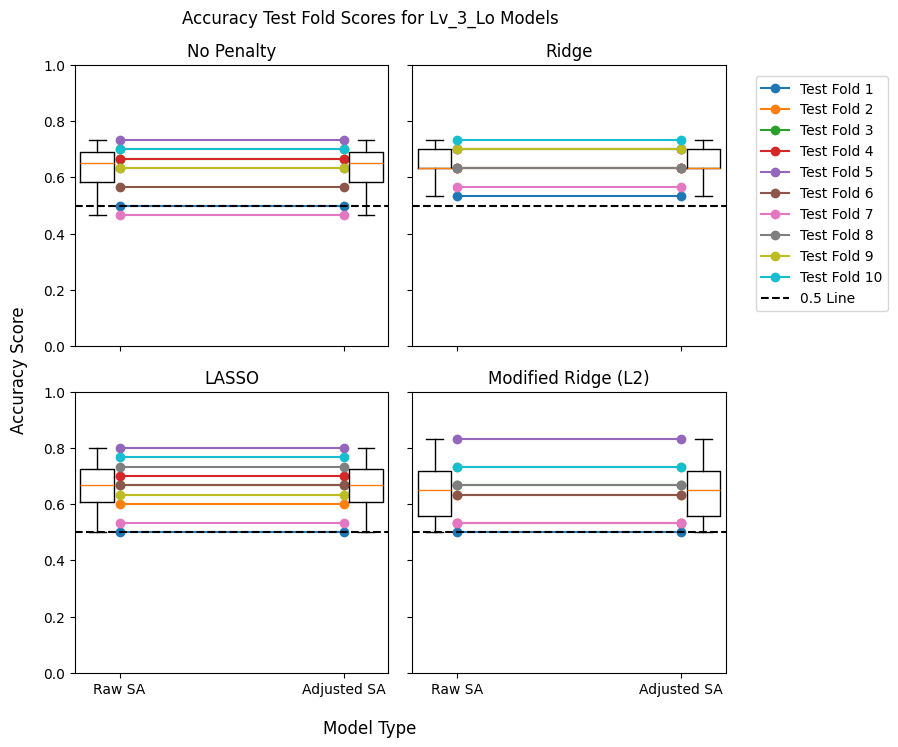

In [32]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "Accuracy", 
    model_names = ["Raw SA", "Adjusted SA"]
)

In [32]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    "Lv_3_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    nan      nan
Ridge                         nan      nan
Modified Ridge (L2)           nan      nan
LASSO                         nan      nan


## Total SA

### F1

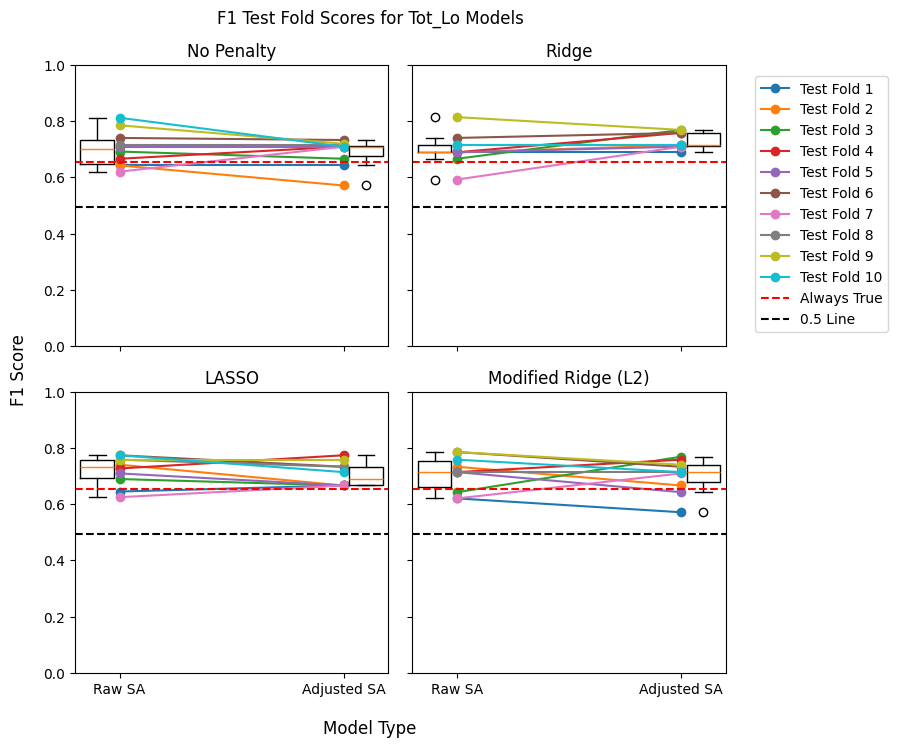

In [33]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "F1", 
    model_names = ["Raw SA", "Adjusted SA"]
)

In [34]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_f1_scores,
        "Dataset Type": "Actual"
    },
    "Tot_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    0.793  0.448
Ridge                         -1.909 0.089
Modified Ridge (L2)           0.313  0.761
LASSO                         1.180  0.268


### Accuracy

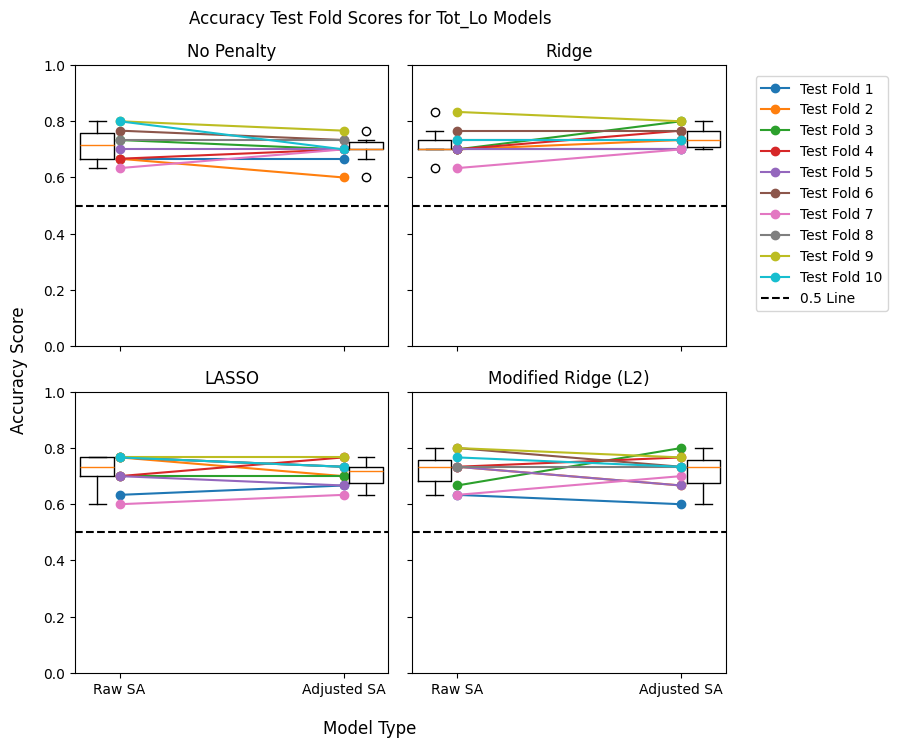

In [34]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_accuracy_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_accuracy_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "Accuracy", 
    model_names = ["Raw SA", "Adjusted SA"]
)

In [35]:
print("Paired (Not Shuffled vs. Shuffled)")
paired_t_test(
    {
        "Data": raw_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    {
        "Data": adj_SA_accuracy_scores,
        "Dataset Type": "Actual"
    },
    "Tot_Lo"
)

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    1.103  0.299
Ridge                         -1.769 0.111
Modified Ridge (L2)           0.318  0.758
LASSO                         0.514  0.619
